# How does human population affect forest area in developed, transitioning, and undeveloped countries?

Using raw data, we modelled human population and forest area as a percent of the total land of a country. As it turned out, using a quadratic model proved to be the best fitting one. The purpose of this project is to model forest area versus human population into the future to visually see whether or not the way things are going is sustainable. To extend this question even further, we broke the countries down by type (developed, transitioning, and undeveloped) as categorized by the United Nations. We, then, modeled the human population and forest area as a percent of total land space in each particular type of country. 

In [817]:
"""imports necessary functions from modsim and creates a pandas object"""

from modsim import *
import pandas as pd

The data we used was categorized individually by country. We then identified the countries in each category (developed, transitioning, and undeveloped) and then seperated them into seperate .csv files.

In [818]:
"""getting initial data from a .csv"""

t_undeveloped = pd.read_csv("ForestP1/Underdeveloped.csv", 
                   names = ['Year', 'Forest Area/Total Land'],
                   header = None)
t_transitioning = pd.read_csv("ForestP1/Transitioning.csv", 
                   names = ['Year', 'Forest Area/Total Land'],
                   header = None)
t_developed = pd.read_csv("ForestP1/Developed.csv", 
                   names = ['Year', 'Forest Area/Total Land'],
                   header = None)

p_undeveloped = pd.read_csv("ForestP1/Underdeveloped-PPL.csv", 
                   names = ['Year', 'Population'],
                   header = None)
p_transitioning = pd.read_csv("ForestP1/Transitioning-PPL.csv", 
                   names = ['Year', 'Population'],
                   header = None)
p_developed = pd.read_csv("ForestP1/Developed-PPL.csv", 
                   names = ['Year', 'Population'],
                   header = None)

--------------------------------------------------------------------------------------------------------------------------------
# Setting Things Up (Kind Of Like Jenga)


This function averages the population data by time. 

In [819]:
def condense_to_avg(data, entries_per_country):
    """
    data - table of data for various countries and years
    entries_per_country - number of data points per country
    
    This function will average the data over each year between all the countries
    and return a more manageable datafram
    """
    
    data_length = len(data['Year'])                          #stores the length of the data

    time = TimeSeries()                                      #stores the data averages 
    
    for i in range (entries_per_country):                    #assigns default state to time
        time[i] = float(0);

    num_of_countries = 0;                                    #keeps track of number of countries to make averages later

    for i in range (data_length):                            #loop tracks totals between countries each year
        num = i % entries_per_country
        
        time[num] += data['Forest Area/Total Land'][i]
        
        if (num == 0):
            num_of_countries += 1
    
    for i in range (entries_per_country):                    #finds the average for each data point
        time[i] = time[i]/num_of_countries

    averages = {'Year' : data['Year'][0:entries_per_country],#creates a new, more manageable dataframe
                'Population' : time}
        
    return averages                                          #returns new dataframe

The function below creates a system object with specified values to be used in creating a model.

In [820]:
def create_sys(data, alpha, beta, t_end):
    """
    data - a dataframe that has two columns (Year and Population)
    alpha - value for quadratic growth model
    beta - value for quadratic growth model
    t_end - value for linear growth model
    
    Returns a system with all important parts
    """
    t_0 = data['Year'][0]                         #sets time zero for data
    
    p_0 = data['Population'][0]                   #sets initial population
    
    system = System(t_0 = t_0,                    #creates system object with necessary variables
                    t_end = t_end,
                    p_0 = p_0,
                    alpha = alpha,
                    beta = beta)
    return system                                 #returns system object

-------------------------------------------------------------------------------------------------------------------------------
# Modeling (Something Other Than Feeeeeeeeeesh)


These functions below utilize the quadratic modeling equation to calculate how much the population will change every year. In addition, as the percentage of total land forest area can take up cannot exceed 100, the update_func_t includes an if statement to make sure that it will not. 

In [822]:
def update_func_t(area, t, system):
    """
    pop - current population
    t - current year
    system - system object containing parameters of the model
    
    Compute and return forest area/total land area for next year with a quadratic model.
    """
    r = system.alpha                         #calculates r for quadratic formula
    K = -r/system.beta                       #calculates K for quatratic formula
    
    area_change = (r*area)*(1-(area/K))      #utilizes r and K to determine the population change
    
    if (area+area_change) >= 100:            # prevents area from exceeding 100 percent
        return 100
    
    return area + area_change                #returns updated population 

In [823]:
def update_func_p(pop, t, system):
    """
    pop - current population
    t - current year
    system - system object containing parameters of the model
    
    Compute and return the population next year with a quadratic model.
    """
    r = system.alpha                         #calculates r for quadratic formula
    K = -r/system.beta                       #calculates K for quatratic formula
    
    pop_change = (r*pop)*(1-(pop/K))         #utilizes r and K to determine the population change
    
    return pop + pop_change                  #returns updated population 

To run the simulation, run_simulation is used which takes an update function and system as a parameter. Then it iterates through a set amount of time and estimates values based on the function passed in.

In [824]:
def run_simulation(system, update_func):
    """
    system - System object
    update_func - function that computes the population next year
    
    simulate the system using any update function
    """
    results = TimeSeries()                                 #creates a timeseries with initial population value to add too
    results[system.t_0] = system.p_0                       
    
    for t in linrange(system.t_0, system.t_end):           #calculates change in population and creates a new value in results
        results[t+1] = update_func(results[t], t, system)
        
    return results                                         #returns timeseries

--------------------------------------------------------------------------------------------------------------------------------
# Plotting (Not Like A Villain)

The create plots function allows you to change the alpha and beta values to fit the particular model whenever calling it. It plots the quadratic model. It calls all the functions necessary to create the plot that we made earlier. 

In [825]:
def create_plots(avgs, alpha, beta, update_func, label, t_end):
    """
    data - simplified dataframe which contains two columns
    alpha - value for quadratic growth model
    beta - value for quadratic growth
    num_of_entries - how many values per country
    
    Returns a time series to plot
    """
    system = create_sys(avgs, alpha, beta, t_end)  #creates a system object with specified values
    
    pop_plot = run_simulation(system, update_func) #runs the simulation and stores timeseries
    
    plot(pop_plot, label = label)                  #plots the simulation
    
    return pop_plot                                #returns the timeseries to be used later

Here, we are plotting the percent forest area model for underdeveloped, transitioning, and developed countries in the same plot. We decided the plot to end at 2050, but you could extend it to predict forest area farther into the future. We are calling the create_plots function.

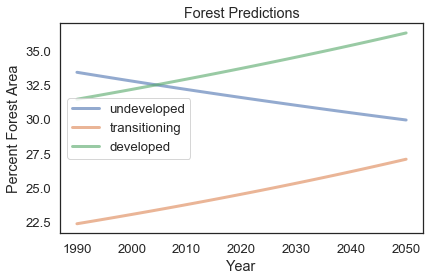

In [826]:
tree_u = create_plots(condense_to_avg(t_undeveloped, 5), 0.0003, -.0000675, update_func_quad, 'undeveloped', 2050)
tree_t = create_plots(condense_to_avg(t_transitioning, 5), 0.00077, .000099, update_func_quad, 'transitioning', 2050)
tree_d = create_plots(condense_to_avg(t_developed, 5), 0.0002, .000065, update_func_quad, 'developed', 2050)

decorate(xlabel = 'Year',
         ylabel = 'Percent Forest Area',
         title = 'Forest Predictions')

Here, we are plotting human population for underdeveloped, transitioning, and developed countries in the same plot.

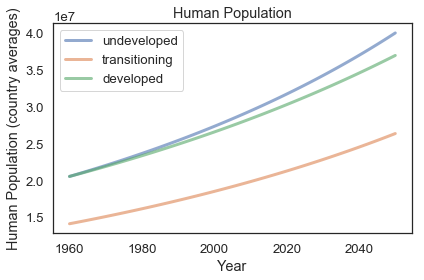

In [828]:
ppl_u = create_plots(p_undeveloped,  0.006, .00000000005, update_func_p, 'undeveloped', 2050)
ppl_t = create_plots(p_transitioning,  .006, .00000000005, update_func_p, 'transitioning', 2050)
ppl_d = create_plots(p_developed,  0.006, .00000000002, update_func_p, 'developed', 2050)

decorate(xlabel = 'Year',
         ylabel = 'Human Population (country averages)',
         title = 'Human Population')

The combine_data function will combine two different sets of data based on time.

In [829]:
def combine_data(data1, data2):
    """
    datax - a timeseries containing data
    
    This function will return a timeseries that combines the data into one 
    based on the earliest shared datapoint
    """
    t_0 = 0                                                    #creates time variables
    t_end = 0
    
    if data1.index[0] < data2.index[0]:                        #finds the later start time
        t_0 = data2.index[0]
    else:
        t_0 = data1.index[0]
        
    if data1.index[len(data1)-1] < data2.index[len(data2)-1]:  #finds the earlier end time
        t_end = data1.index[len(data1)-1]
    else:
        t_end = data2.index[len(data2)-1]
    
    results = TimeSeries()                                     #creates a timeseries
    time = [t_0]                                               #creates a list with the intial value of t_0
    
    for i in range(t_end - t_0 -1):                            #adding more values to the time list by increments of 1
        time.append(time[i]+1)
        
    for t in time:                                             #fills results with data1 vs data2
        results[data1[round(t)]+1] = data2[round(t)+1]         

    return results                                             #returns the timeseries

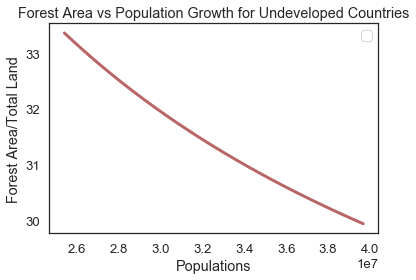

In [830]:
plot(combine_data(ppl_u, tree_u), 'darkred')

decorate(title = 'Forest Area vs Population Growth for Undeveloped Countries',
         xlabel = 'Populations',
         ylabel = 'Forest Area/Total Land')

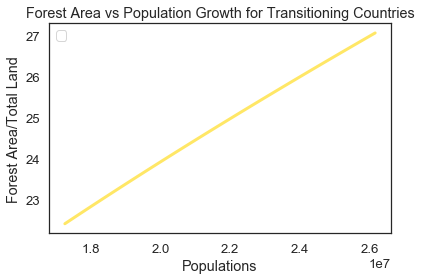

In [831]:
plot(combine_data(ppl_t, tree_t), 'gold')

decorate(title = 'Forest Area vs Population Growth for Transitioning Countries',
         xlabel = 'Populations',
         ylabel = 'Forest Area/Total Land')

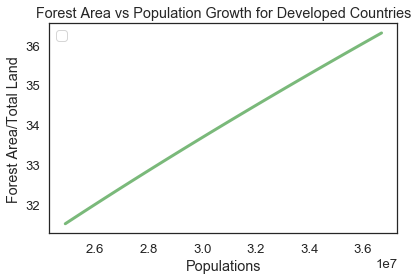

In [832]:
plot(combine_data(ppl_d, tree_d), 'forestgreen')

decorate(title = 'Forest Area vs Population Growth for Developed Countries',
         xlabel = 'Populations',
         ylabel = 'Forest Area/Total Land')

--------------------------------------------------------------------------------------------------------------------------------
# Conclusion

From our model, we can predict that as population increases, percentage of forest area decreases in underdeveloped countries. In transitioning and developed countries, however, the percent of total land that forests take up increases as human population goes up. In developed countries, though, the area forests take up increases more rapidly than transitioning countries. 